In [1]:
import numpy as np
import pandas as pd
import datetime as dt

#作图
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

#保存模型
import joblib

import warnings
warnings.filterwarnings('ignore')

# Data

In [2]:
data = pd.read_csv('survey_results_public.csv')
data.head()

,Respondent,Professional,ProgramHobby,Country,University,EmploymentStatus,FormalEducation,MajorUndergrad,HomeRemote,CompanySize,...,StackOverflowMakeMoney,Gender,HighestEducationParents,Race,SurveyLong,QuestionsInteresting,QuestionsConfusing,InterestedAnswers,Salary,ExpectedSalary
0,1,Student,"Yes, both",United States,No,"Not employed, and not looking for work",Secondary school,NaN,NaN,NaN,...,Strongly disagree,Male,High school,White or of European descent,Strongly disagree,Strongly agree,Disagree,Strongly agree,NaN,NaN
1,2,Student,"Yes, both",United Kingdom,"Yes, full-time",Employed part-time,Some college/university study without earning ...,Computer science or software engineering,"More than half, but not all, the time",20 to 99 employees,...,Strongly disagree,Male,A master's degree,White or of European descent,Somewhat agree,Somewhat agree,Disagree,Strongly agree,NaN,37500.0
2,3,Professional developer,"Yes, both",United Kingdom,No,Employed full-time,Bachelor's degree,Computer science or software engineering,"Less than half the time, but at least one day ...","10,000 or more employees",...,Disagree,Male,A professional degree,White or of European descent,Somewhat agree,Agree,Disagree,Agree,113750.0,NaN
3,4,Professional non-developer who sometimes write...,"Yes, both",United States,No,Employed full-time,Doctoral degree,A non-computer-focused engineering discipline,"Less than half the time, but at least one day ...","10,000 or more employees",...,Disagree,Male,A doctoral degree,White or of European descent,Agree,Agree,Somewhat agree,Strongly agree,NaN,NaN
4,5,Professional developer,"Yes, I program as a hobby",Switzerland,No,Employed full-time,Master's degree,Computer science or software engineering,Never,10 to 19 employees,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [3]:
schema = pd.read_csv('survey_results_schema.csv')
schema.head()

,Column,Question
0,Respondent,Respondent ID number
1,Professional,Which of the following best describes you?
2,ProgramHobby,Do you program as a hobby or contribute to ope...
3,Country,In which country do you currently live?
4,University,"Are you currently enrolled in a formal, degree..."


In [4]:
#考虑全职developer的数据
data = data[data['EmploymentStatus']=='Employed full-time']

In [5]:
#考虑收入为正的developer的数据
data = data[data['Salary']>0]

# EDA

In [6]:
data.describe()

,Respondent,CareerSatisfaction,JobSatisfaction,HoursPerWeek,StackOverflowSatisfaction,Salary,ExpectedSalary
count,12438.000000,12409.000000,12400.000000,5472.000000,11590.000000,12438.000000,0.0
mean,26098.866297,7.493674,6.960081,2.641082,8.512252,57381.580844,NaN
std,15786.528346,1.736553,2.129550,5.455677,1.324734,39871.944002,NaN
min,3.000000,0.000000,0.000000,0.000000,0.000000,0.014682,NaN
25%,12095.500000,7.000000,6.000000,0.000000,8.000000,27956.989247,NaN
50%,26038.000000,8.000000,7.000000,1.000000,9.000000,51297.025641,NaN
75%,41320.750000,9.000000,8.000000,2.000000,10.000000,80608.870968,NaN
max,51391.000000,10.000000,10.000000,40.000000,10.000000,197000.000000,NaN


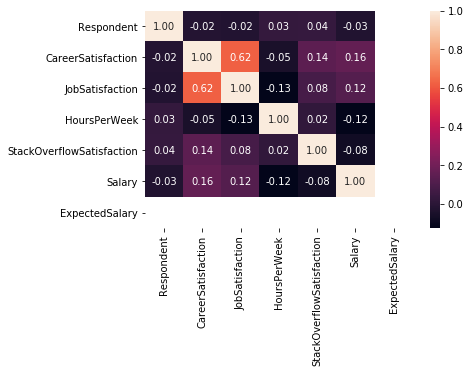

In [7]:
#相关性矩阵
sns.heatmap(data.corr(), annot=True, fmt=".2f");

## Q1:全职开发者中最流行的IDE？

In [8]:
#将嵌套的列表拆开
def flatten(input_list):
    output_list = []
    while True:
        if input_list == []:
            break
        for index, i in enumerate(input_list):
            if type(i)== list:
                input_list = i + input_list[index+1:]
                break
            else:
                output_list.append(i)
                input_list.pop(index)
                break
    return output_list

In [9]:
ide_list = [x for x in data['IDE'].dropna().str.split(';')]
ide_list = flatten(ide_list)

In [10]:
ide_list = [x.strip() for x in ide_list]

In [11]:
result_list = []
for ide in set(ide_list):
    num = ide_list.count(ide)
    result_list.append({
        'IDE': ide,
        'Num': num,
        'Percent':num/data['IDE'].dropna().shape[0]
    })
df_result = pd.DataFrame(result_list, columns=['IDE', 'Num', 'Percent'])
#删除nan数据
df_result.dropna(inplace=True)

df_result.set_index('IDE', inplace=True)

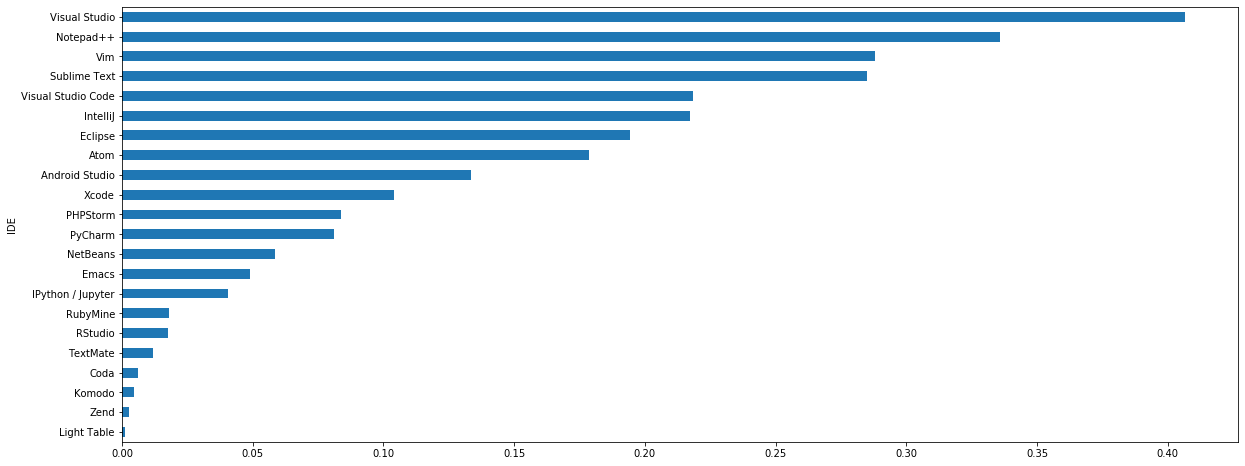

In [12]:
#不同IDE的用户占比
df_result.sort_values('Percent', inplace=True)

df_result['Percent'].plot(kind='barh', figsize=(20,8));

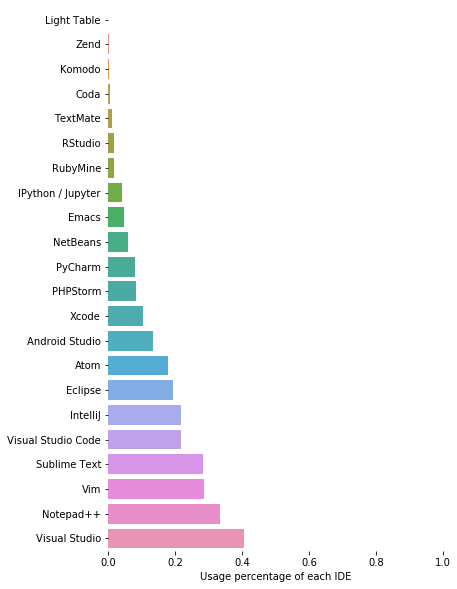

In [13]:
#seaborn作图，post用
f, ax = plt.subplots(figsize=(6, 10))
sns.barplot(x=df_result.Percent, y=df_result.index)

ax.set(xlim=(0, 1), ylabel="",
       xlabel="Usage percentage of each IDE")
sns.despine(left=True, bottom=True)

- 最流行的IDE是VS，其次是Notepad++, Vim和Sublime text占比相当；

### Q:对于编程年限在1年内的开发者而言，最流行的IDE是？

In [37]:
#数据子集
df = data[data['YearsProgram']=='Less than a year']

In [39]:
ide_list = [x for x in df['IDE'].dropna().str.split(';')]
ide_list = flatten(ide_list)

ide_list = [x.strip() for x in ide_list]

result_list = []
for ide in set(ide_list):
    num = ide_list.count(ide)
    result_list.append({
        'IDE': ide,
        'Num': num,
        'Percent':num/df.shape[0]
    })
df_result = pd.DataFrame(result_list, columns=['IDE', 'Num', 'Percent'])
#删除nan数据
df_result.dropna(inplace=True)
df_result.sort_values('Num', ascending=False, inplace=True)

df_result.set_index('IDE', inplace=True)

df_result

,Num,Percent
IDE,,
Visual Studio,23,0.319444
Sublime Text,20,0.277778
Notepad++,19,0.263889
Android Studio,12,0.166667
Visual Studio Code,10,0.138889
Eclipse,10,0.138889
Xcode,8,0.111111
Vim,8,0.111111
Atom,7,0.097222


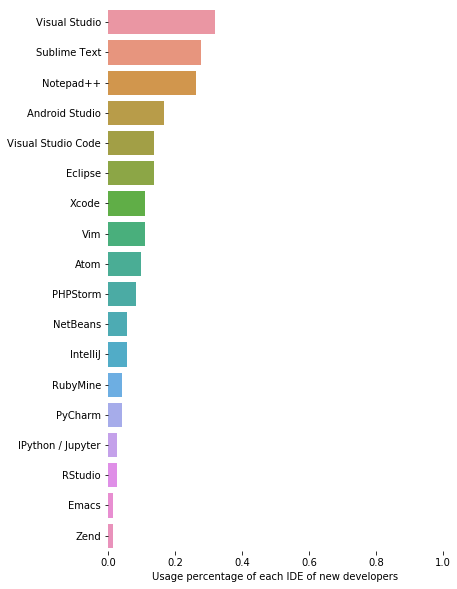

In [41]:
#seaborn作图，post用
f, ax = plt.subplots(figsize=(6, 10))
sns.barplot(x=df_result.Percent, y=df_result.index)

ax.set(xlim=(0, 1), ylabel="",
       xlabel="Usage percentage of each IDE of new developers")
sns.despine(left=True, bottom=True)

- VS仍然是热门的IDE，入手简单的Sublime text的排名上升，对于新手来说，Sublime是不错的选择。

## Q2:不同编程经验的收入差异？

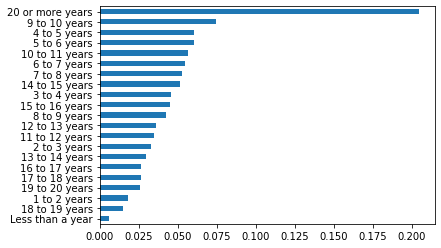

In [14]:
#不同编程年限水平的分布
years = data['YearsProgram'].value_counts().sort_values()/data.shape[0]
years.plot.barh();

In [15]:
#将编程年限数值化
years_program_dict={
    'Less than a year':0.5,
    '1 to 2 years':1.5,
    '2 to 3 years':2.5,
    '3 to 4 years':3.5,
    '4 to 5 years':4.5,
    '5 to 6 years':5.5,
    '6 to 7 years':6.5,
    '7 to 8 years':7.5,
    '8 to 9 years':8.5,
    '9 to 10 years':9.5,
    '10 to 11 years':10.5,
    '11 to 12 years':11.5,
    '12 to 13 years':12.5,
    '13 to 14 years':13.5,
    '14 to 15 years':14.5,
    '15 to 16 years':15.5,
    '16 to 17 years':16.5,
    '17 to 18 years':17.5,
    '18 to 19 years':18.5,
    '19 to 20 years':19.5,
    '20 or more years':20
}

df = data.dropna(subset=['YearsProgram'])
#转换
df['YearsProgram'] = df['YearsProgram'].map(years_program_dict)

In [16]:
#不同年限的收入中位数
years_list = df['YearsProgram'].value_counts().index.tolist()
result = []
for year in years_list:
    df_temp = df[df['YearsProgram']==year]
    result.append({
        'Years':year,
        'Salary':int(np.round(df_temp['Salary'].median(), 0)),
        'Count':df_temp.shape[0],
        'Percent':df_temp.shape[0]/df.shape[0]
    })
df_result = pd.DataFrame(result, columns=['Years', 'Salary', 'Count', 'Percent'])
df_result.sort_values('Salary', ascending=False, inplace=True)
df_result.reset_index(drop=True, inplace=True)

#累计求和
df_result['Cum_percent'] = df_result['Percent'].cumsum()
df_result

,Years,Salary,Count,Percent,Cum_percent
0,20.0,79545,2541,0.204474,0.204474
1,17.5,67270,328,0.026394,0.230868
2,18.5,65000,188,0.015128,0.245997
3,19.5,65000,323,0.025992,0.271988
4,16.5,60108,330,0.026555,0.298543
5,14.5,59140,639,0.051420,0.349964
6,15.5,56206,559,0.044983,0.394946
7,13.5,53030,371,0.029854,0.424801
8,11.5,51000,435,0.035004,0.459805
9,12.5,48815,452,0.036372,0.496178


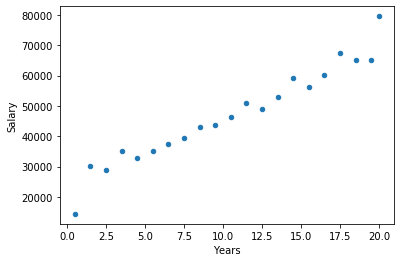

In [17]:
#编程年限和收入中位数的散点图
df_result.plot.scatter(x='Years', y='Salary');

In [18]:
#拟合方程
from sklearn.linear_model import LinearRegression
linreg = LinearRegression()
linreg.fit(np.array(df_result['Years']).reshape(-1,1), df_result['Salary'])

#方程系数
print('斜率',linreg.coef_[0])
print('截距', linreg.intercept_)
print('y={}*x+{}'.format(linreg.coef_[0], linreg.intercept_))

斜率 2475.2364234262445
截距 21259.999373629817
y=2475.2364234262445*x+21259.999373629817


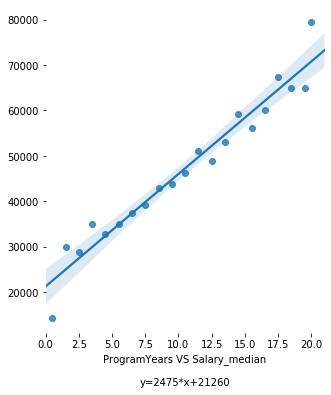

In [20]:
#作图，medium展示用
f, ax = plt.subplots(figsize=(5, 6))
sns.regplot(x='Years', y='Salary', data=df_result)
ax.set(xlim=(0, 21), ylabel="",
       xlabel="ProgramYears VS Salary_median\n\ny=2475*x+21260")
sns.despine(left=True, bottom=True)

- 总体来说，编程经验越丰富，收入也会更高；
- 对于全职的开发者来说，可以预期没过一年，工资可以上涨2500。如果你没有达到这个水平，说明你的工资增长幅度落后平均水平了。

## Q3:不同专业对收入的影响？那个专业工资最高？数学专业在什么水平？

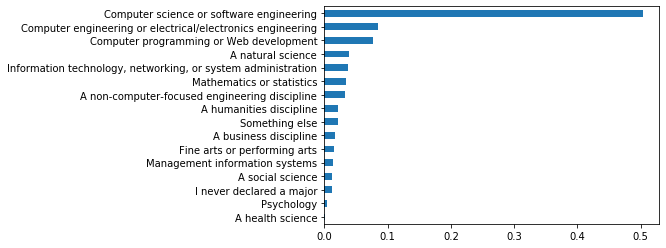

In [42]:
#不同专业的分布
major = data['MajorUndergrad'].value_counts().sort_values()/data.shape[0]
major.plot.barh();

In [43]:
#考虑全职的数据
df = data.dropna(subset=['MajorUndergrad'])

major_list = df['MajorUndergrad'].value_counts().index.tolist()
result = []
for major in major_list:
    df_temp = df[df['MajorUndergrad']==major]
    result.append({
        'Major':major,
        'Salary':int(np.round(df_temp['Salary'].median(), 0)),
        'Count':df_temp.shape[0],
        'Percent':df_temp.shape[0]/df.shape[0]
    })
df_result = pd.DataFrame(result, columns=['Major', 'Salary', 'Count', 'Percent'])
df_result.sort_values('Salary', ascending=False, inplace=True)
df_result.set_index('Major', drop=True, inplace=True)

#累计求和
df_result['Cum_percent'] = df_result['Percent'].cumsum()
df_result

,Salary,Count,Percent,Cum_percent
Major,,,,
Psychology,75269,53,0.004564,0.004564
Management information systems,70000,175,0.015069,0.019633
A social science,69892,161,0.013864,0.033497
Fine arts or performing arts,68182,191,0.016447,0.049944
A business discipline,64516,217,0.018686,0.068630
A humanities discipline,61000,273,0.023508,0.092138
Mathematics or statistics,60108,434,0.037372,0.129510
A natural science,60000,482,0.041505,0.171015
I never declared a major,57015,156,0.013433,0.184448


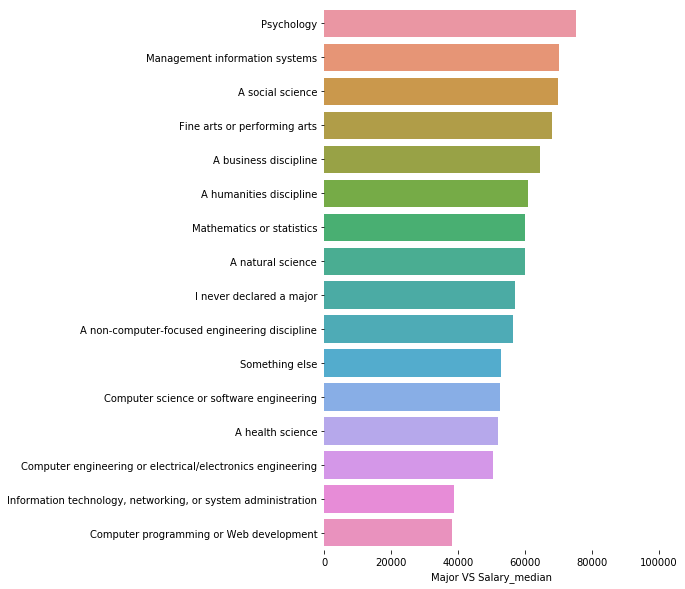

In [44]:
#seaborn作图，medium用
f, ax = plt.subplots(figsize=(6, 10))
sns.barplot(x=df_result.Salary, y=df_result.index)

ax.set(xlim=(0, 100000), ylabel="",
       xlabel="Major VS Salary_median")
sns.despine(left=True, bottom=True)

- Psychology专业的全职人员的平均中位数超过75000，位列榜首；
- Mathematics or statistics	专业的的工资中位数水平排在第七，为60108。只有9%的人比数学专业的收入水平更高。

## Q4:不同教育水平对收入的影响？Bachelor、Master和Doctoral之间的差异？

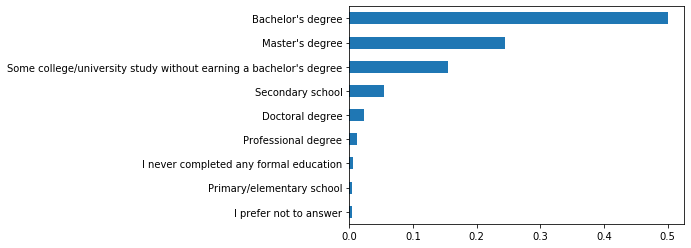

In [24]:
#不同教育水平的分布
education = data['FormalEducation'].value_counts().sort_values()/data.shape[0]
education.plot.barh();

In [25]:
#考虑全职的数据
df = data.dropna(subset=['FormalEducation'])

education_list = df['FormalEducation'].value_counts().index.tolist()
result = []
for education in education_list:
    df_temp = df[df['FormalEducation']==education]
    result.append({
        'Education':education,
        'Salary':int(np.round(df_temp['Salary'].median(), 0)),
        'Count':df_temp.shape[0],
        'Percent':df_temp.shape[0]/df.shape[0]
    })
df_result = pd.DataFrame(result, columns=['Education', 'Salary', 'Count', 'Percent'])
df_result.sort_values('Salary', ascending=False, inplace=True)
df_result.set_index('Education', drop=True, inplace=True)

#累计求和
df_result['Cum_percent'] = df_result['Percent'].cumsum()
df_result

,Salary,Count,Percent,Cum_percent
Education,,,,
Doctoral degree,65115,288,0.023155,0.023155
Primary/elementary school,63500,51,0.004100,0.027255
Bachelor's degree,53750,6230,0.500884,0.528140
Master's degree,50538,3031,0.243689,0.771828
Some college/university study without earning a bachelor's degree,50000,1929,0.155089,0.926918
Secondary school,38710,667,0.053626,0.980543
I never completed any formal education,37757,60,0.004824,0.985367
I prefer not to answer,37634,41,0.003296,0.988664
Professional degree,32258,141,0.011336,1.000000


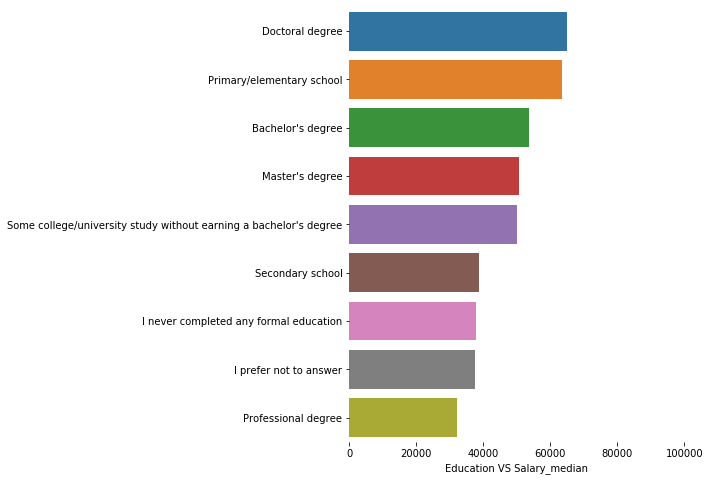

In [26]:
#seaborn作图，medium用
f, ax = plt.subplots(figsize=(6, 8))
sns.barplot(x=df_result.Salary, y=df_result.index)

ax.set(xlim=(0, 100000), ylabel="",
       xlabel="Education VS Salary_median")
sns.despine(left=True, bottom=True)

- 学历高，并不一定收入就高。但从图上看，高学历的人不太会获得一个相对较低的收入。
- 从中位数来看，Bachelor和Master的水平相当，而Doctoral则高出一大截。短期来看，从Bachelor到Master，工资水平没有明显的增长，但长期来看，达到Doctoral就会有大幅提升。

# Modeling

In [27]:
def clean_data(df):
    # Drop rows with missing salary values
    df = df.dropna(subset=['Salary'], axis=0)
    y = df['Salary']
    
    #Drop respondent and expected salary columns
    df = df.drop(['Respondent', 'ExpectedSalary', 'Salary'], axis=1)
    
    # Fill numeric columns with the mean
    num_vars = df.select_dtypes(include=['float', 'int']).columns
    for col in num_vars:
        df[col].fillna((df[col].mean()), inplace=True)
        
    # Dummy the categorical variables
    cat_vars = df.select_dtypes(include=['object']).copy().columns
    for var in  cat_vars:
        # for each cat add dummy var, drop original column
        df = pd.concat([df.drop(var, axis=1), pd.get_dummies(df[var], prefix=var, prefix_sep='_', drop_first=True)], axis=1)
    
    X = df
    return X, y
    
#Use the function to create X and y
X, y = clean_data(data)    

In [28]:
#衡量工具
def rmspe(y, yhat):
    return np.sqrt(np.mean((yhat/y-1) ** 2))

def rmspe_xg(yhat, y):
    y = y.get_label()
    return "rmspe", rmspe(y, yhat)

In [29]:
#数据划分
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

## Base Model

In [30]:
#随机森林
from sklearn.ensemble import RandomForestRegressor

#开始时间
s_time = dt.datetime.now()

#训练模型
rfr = RandomForestRegressor(n_estimators = 15)
rfr.fit(X_train, y_train)

#验证
y_pred = rfr.predict(X_test)
error = rmspe(y_test, y_pred)
print('RMSPE: {:.4f}'.format(error))

#结束时间
e_time = dt.datetime.now()
print('本次训练共计耗时：{}秒'.format((e_time-s_time).seconds))

#保存模型
joblib.dump(rfr, 'saved_model/RandomForest.pkl')
print('模型保存完成，保存名称：{}'.format('RandomForest'))

RMSPE: 7510.5753
本次训练共计耗时：139秒
模型保存完成，保存名称：RandomForest


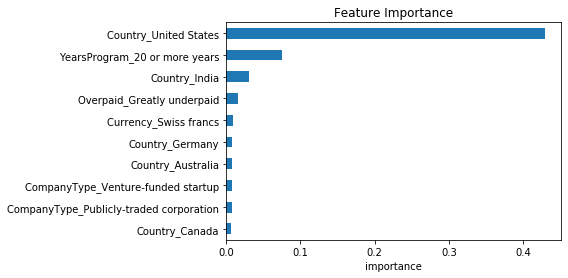

In [31]:
# 最重要的10个特征
feat_importances = pd.Series(rfr.feature_importances_, index=X_train.columns)
feat_importances.nlargest(10).sort_values(ascending = True).plot(kind='barh')
plt.xlabel('importance')
plt.title('Feature Importance');

## XGB Model

In [33]:
import xgboost as xgb

#开始时间
s_time = dt.datetime.now()


params = {"objective": "reg:linear", # 默认值，
          "booster" : "gbtree",      # 需要使用的上升模型。可选gbtree（树）或gblinear（线性函数），默认为gbtree。
          "eta": 0.1,               # 收缩步长，即学习速率，取值范围是，默认为０．３。在更新叶子节点的时候，权重乘以ｅｔａ，以避免在更新过程中的过拟合。
          "max_depth": 10,           # 每棵树的最大深度，取值范围，默认为６。树越深，越容易过拟合。
          "subsample": 0.9,          # 训练的实例样本占整体实例样本的比例，取值范围是（０，１］，默认为１。值为0.5时意味着Xgboost随机抽取一半的数据实例来生成树模型，这样能防止过拟合。
          "colsample_bytree": 0.7,   # 在构建每棵树时，列（特征）的子样本比，参数值的范围是（０，１］。
          "silent": 1,               # silent mode。
          "seed": 10                 # 随机数种子，为确保数据的可重现性，默认为０。
          }
#训练次数
num_boost_round = 4000

dtrain = xgb.DMatrix(X_train, y_train)
dtest = xgb.DMatrix(X_test, y_test)
watchlist = [(dtrain, 'train'), (dtest, 'test')]

#训练模型
model = xgb.train(params, dtrain, num_boost_round, evals=watchlist, \
  early_stopping_rounds= 100, feval=rmspe_xg, verbose_eval=True)

#验证
y_pred = model.predict(dtest)
error = rmspe(y_test, y_pred)
print('RMSPE: {:.4f}'.format(error))

#结束时间
e_time = dt.datetime.now()
print('本次训练共计耗时：{}秒'.format((e_time-s_time).seconds))

#保存模型
joblib.dump(model, 'saved_model/xgb.pkl')
print('模型保存完成，保存名称：{}'.format('xgb'))

RMSPE: 6419.8727
本次训练共计耗时：4012秒
模型保存完成，保存名称：xgb
